In [9]:
import pandas as pd
import numpy as np
from py_pcha import PCHA

df = pd.read_csv("E:/Opossum_Paper/Figure 3/mouse_triangle_integrated.csv")
df = df.loc[df["method"] == "Stereo-seq"]
X = np.array(df[["X", "Y"]])

XC, S, C, SSE, varexpl = PCHA(X.T, noc=3, delta=0.1)

In [13]:
XC.shape

(2, 3)

In [15]:
XC

matrix([[-23.36819121,  11.87301209,  18.04776374],
        [  1.24523004,  31.10435784, -10.64795967]])

In [16]:
XC_r = XC[:, [2, 1, 0]]

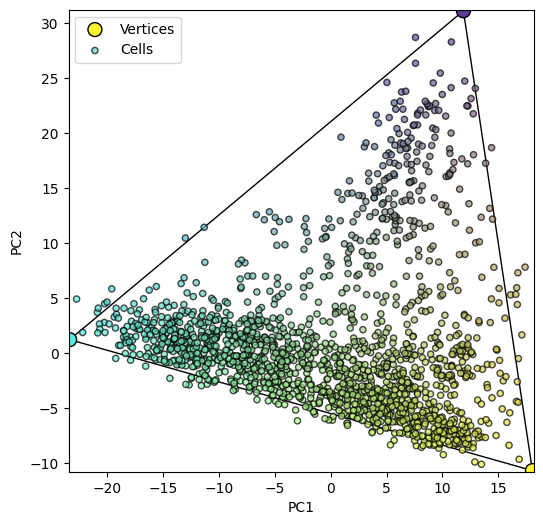

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import pandas as pd
from scipy.spatial.distance import cdist

# Define three vertices of the triangle in PC space
cells = np.array(X)  # (N, 2) - N cells with 2D coordinates (PC1, PC2)
vertices = np.array(XC_r.T)  # (3, 2) - Three vertices defining the triangle
colors = np.array([[1.        , 0.95294118, 0.18823529], [0.36863, 0.23529, 0.60000], [0.31764706, 0.94117647, 0.89019608]])  # (3, 3) - RGB colors for each vertex

# Function to compute barycentric coordinates
def barycentric_coords(triangle, points):
    A, B, C = triangle[0], triangle[1], triangle[2]  # Each (2,) - Extract vertices
    v0, v1 = B - A, C - A  # (2,) - Basis vectors of the triangle
    v2 = points - A  # (N, 2) - Vectors from A to each cell
    
    d00 = np.dot(v0, v0)  # Scalar - Dot product of v0 with itself
    d01 = np.dot(v0, v1)  # Scalar - Dot product of v0 with v1
    d11 = np.dot(v1, v1)  # Scalar - Dot product of v1 with itself
    d20 = np.sum(v2 * v0, axis=1)  # (N,) - Dot product of v2 with v0
    d21 = np.sum(v2 * v1, axis=1)  # (N,) - Dot product of v2 with v1
    
    denom = d00 * d11 - d01 * d01  # Scalar - Determinant of the matrix
    v = (d11 * d20 - d01 * d21) / denom  # (N,) - Barycentric coordinate for vertex B
    w = (d00 * d21 - d01 * d20) / denom  # (N,) - Barycentric coordinate for vertex C
    u = 1 - v - w  # (N,) - Barycentric coordinate for vertex A
    
    return np.vstack((u, v, w)).T  # (N, 3) - Barycentric coordinates for all cells

# Ensure correct shape for vertices
if vertices.shape[1] != 2:
    vertices = vertices.T  # Ensure (3,2) shape

# Compute barycentric coordinates for each cell
bary_coords = barycentric_coords(vertices, cells)  # (N, 3)

# Ensure all barycentric coordinates are within valid range
bary_coords = np.clip(bary_coords, 0, 1)  # Clamps values to [0,1]

# Compute color for each cell by mixing vertex colors
cell_colors = np.dot(bary_coords, colors)  # (N, 3) - Weighted RGB values

# Ensure final computed colors are within valid RGB range [0,1]
cell_colors = np.clip(cell_colors, 0, 1)
cell_names = df["cell"]  # Generate cell names
rgb_df = pd.DataFrame(cell_colors, columns=["R", "G", "B"], index=cell_names)

# Calculate distances from each cell to each vertex
distances = cdist(cells, vertices, metric='euclidean')  # (N, 3) - Distance from cells to vertices

# Add distances to the RGB DataFrame
for i, vertex_label in enumerate(['Vertex_B', 'Vertex_C', 'Vertex_A']):
    rgb_df[f'Distance_to_{vertex_label}'] = distances[:, i]

# Save RGB triplets with cell names to CSV
rgb_df.to_csv("E:/Opossum_Paper/Figure 3/mouse_integrated_PC_colors.csv")

# Plot the triangular colormap
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(np.min(vertices[:, 0]) - 0.1, np.max(vertices[:, 0]) + 0.1)
ax.set_ylim(np.min(vertices[:, 1]) - 0.1, np.max(vertices[:, 1]) + 0.1)
ax.triplot(vertices[:, 0], vertices[:, 1], [[0, 1, 2]], color='k', linewidth=1)
ax.scatter(vertices[:, 0], vertices[:, 1], c=colors, edgecolor='black', s=100, label='Vertices')
ax.scatter(cells[:, 0], cells[:, 1], c=cell_colors, s=20, edgecolor='k', alpha=0.7, label='Cells')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
plt.show()

In [18]:
XC_r

matrix([[ 18.04776374,  11.87301209, -23.36819121],
        [-10.64795967,  31.10435784,   1.24523004]])

In [4]:
rgb_df

,R,G,B,Distance_to_Vertex_A,Distance_to_Vertex_B,Distance_to_Vertex_C
cell,,,,,,
59317793335536,0.414767,0.884701,0.770724,38.043208,36.435382,8.768120
59154584578296,0.353253,0.781453,0.799632,39.970253,32.442495,10.764480
58978490919059,0.483732,0.765414,0.659251,31.121172,27.819554,18.747755
58935541246083,0.381018,0.810681,0.780739,38.667453,33.185445,10.494903
58420145170637,0.714939,0.834549,0.443315,17.012888,30.739698,30.720317
...,...,...,...,...,...,...
31413390814895,0.395699,0.818839,0.768295,37.845757,33.184711,10.859360
30842160164381,0.464254,0.692084,0.654734,31.664529,24.040862,21.424408
30799210491495,0.446775,0.873638,0.733889,35.602246,34.885849,11.326837
